## <b> Convolutional Neural Network for Brain Tumor Detection  </b> 

In [ ]:
!pip install split-folders
!pip install torch-summary

In [1]:
# libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy 
import os 
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau 
import torch.nn as nn 
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from tqdm.notebook import trange, tqdm #  progress of tasks.
from torch import optim
import utils
# from transforms_utils import convert_grayscale_to_rgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
class BrainTumorImageFolder(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        image = self.loader(path)
        
  
        if image.mode != 'RGB':
        
            image = image.convert('RGB')
            
        if self.transform is not None:
            image = self.transform(image)
            
        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return image, target


## <b>2 Dataset</b> 

<div <b>Load Dataset</b>
</div>

In [4]:
labels_df = pd.read_csv('/Users/sandrageorgiev/Downloads/VVB-project/metadata.csv')
print(labels_df.head().to_markdown())

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


In [5]:
os.listdir('/Users/sandrageorgiev/Downloads/VVB-project/Brain Tumor Data Set')

['.DS_Store', 'Healthy', 'Brain Tumor']

In [6]:
healthy_count = len(os.listdir(os.path.join('/Users/sandrageorgiev/Downloads/VVB-project/Brain Tumor Data Set', "Healthy")))
tumor_count = len(os.listdir(os.path.join('/Users/sandrageorgiev/Downloads/VVB-project/Brain Tumor Data Set', "Brain Tumor")))

print(f"Number of images in Healthy folder: {healthy_count}")
print(f"Number of images in Brain Tumor folder: {tumor_count}")

Number of images in Healthy folder: 2087
Number of images in Brain Tumor folder: 2513


In [7]:
labels_df.shape

(4600, 6)

## <b>3 Data Preparation </b> 

<div <b> Splitting Dataset</b>
</div>



In [8]:
data_dir = '/Users/sandrageorgiev/Downloads/VVB-project/Brain Tumor Data Set'
data_dir = pathlib.Path(data_dir)

splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8, 0.1, 0.1))

data_dir = '/Users/sandrageorgiev/Downloads/VVB-project/brain'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [00:16, 284.36 files/s]


## <b>4 Image Augmentation Definitions</b> 

In [9]:
transform = transforms.Compose([  
    # transforms.Lambda(utils.convert_grayscale_to_rgb),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(
        degrees=(0, 0),          # No rotation applied (degrees=0)
        translate=(0.05, 0.05),  # Slight shifting
        scale=(0.95, 1.05),      # Slight zoom
        shear=5                  # Light shear
    ),
    transforms.ColorJitter(
        brightness=0.05,
        contrast=0.05,
        saturation=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [10]:
train_set = BrainTumorImageFolder(data_dir.joinpath("train"), transform=transform) 
train_set.transform
val_set = BrainTumorImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform
test_set = BrainTumorImageFolder(data_dir.joinpath("test"), transform=transform) 
test_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.05, 0.05), scale=(0.95, 1.05), shear=[-5.0, 5.0])
    ColorJitter(brightness=(0.95, 1.05), contrast=(0.95, 1.05), saturation=(0.95, 1.05), hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

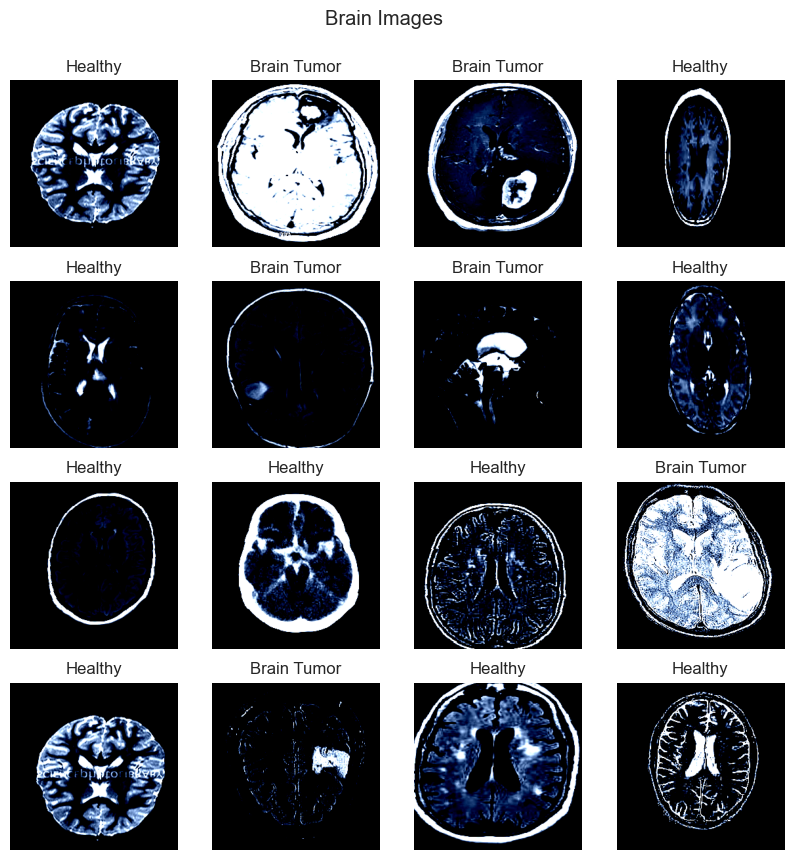

In [11]:
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
} 
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Brain Images', y=0.95)
plt.show()

## <b>5  Creating Dataloaders</b> 

In [12]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True, num_workers = 0)


In [13]:
for key, value in {'Training data': train_loader, "Validation data": val_loader, "Test data": test_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64
Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64
Test data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64


## <b>6  Define Brain Tumor Classifier</b> 


In [14]:
def findConv2dOutShape(hin,win,conv,pool=2):
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [15]:
class CNN_TUMOR(nn.Module):
    
    def __init__(self, params):
        
        super(CNN_TUMOR, self).__init__()
    
        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"] 
        num_fc1 = params["num_fc1"]  
        num_classes = params["num_classes"] 
        self.dropout_rate = params["dropout_rate"] 
        
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):

        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [16]:
params_model={
        "shape_in": (3,256,256), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

cnn_model = CNN_TUMOR(params_model)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [17]:
summary(cnn_model, input_size=(3, 256, 256),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 254, 254]             224
            Conv2d-2         [-1, 16, 125, 125]           1,168
            Conv2d-3           [-1, 32, 60, 60]           4,640
            Conv2d-4           [-1, 64, 28, 28]          18,496
            Linear-5                  [-1, 100]       1,254,500
            Linear-6                    [-1, 2]             202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 7.11
Params size (MB): 4.88
Estimated Total Size (MB): 12.74
----------------------------------------------------------------


## <b>7  Loss Function Definition</b> 

In [18]:
loss_func = nn.NLLLoss(reduction="sum")

## <b>8 Optimiser Definition</b> 

In [19]:
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

## <b>9  Training Model</b> 

In [20]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) 
    pred = output.argmax(dim=1, keepdim=True)
    metric_b=pred.eq(target.view_as(pred)).sum().item() 
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) 
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) 
        run_loss+=loss_b        

        if metric_b is not None: 
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data) 
    metric=t_metric/float(len_data) 
    
    return loss, metric


 ##  <b> Training Function</b>



In [21]:
def Train_Val(model, params,verbose=False):
    
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    loss_history={"train": [],"val": []} 
    metric_history={"train": [],"val": []} 
    best_model_wts = copy.deepcopy(model.state_dict()) 

    best_loss=float('inf') 


    
    for epoch in tqdm(range(epochs)):
        
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

        


        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        



        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        

        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

##
<div>
    <b> Training Process </b>
</div>

In [22]:


params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 60,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist = Train_Val(cnn_model,params_train)

  0%|          | 0/60 [00:00<?, ?it/s]

## <b>10  Evaluation Metric Visualization </b> 

<Axes: >

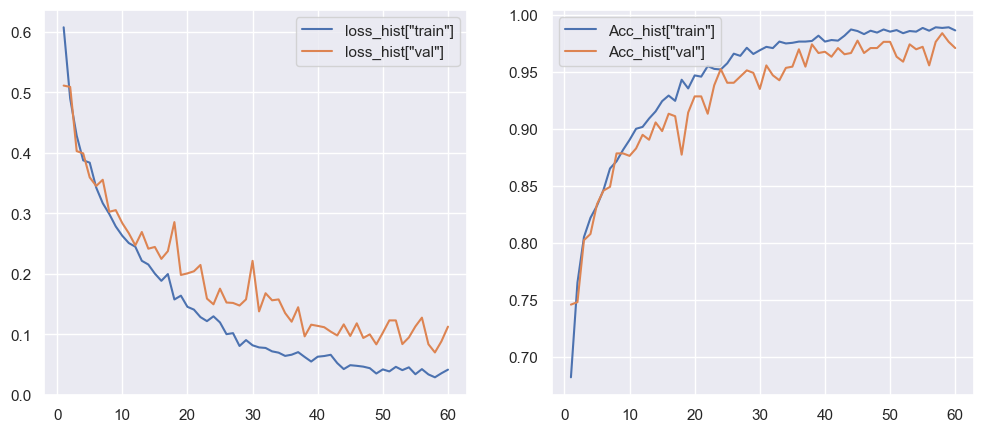

In [23]:
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Acc_hist["val"]')

## <div> <b> Confusion_Matrix </b>
</div>

In [24]:
def Ture_and_Pred(test_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()
        
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred


# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(test_loader, cnn_model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       252
         1.0       0.95      0.98      0.97       210

    accuracy                           0.97       462
   macro avg       0.97      0.97      0.97       462
weighted avg       0.97      0.97      0.97       462
 


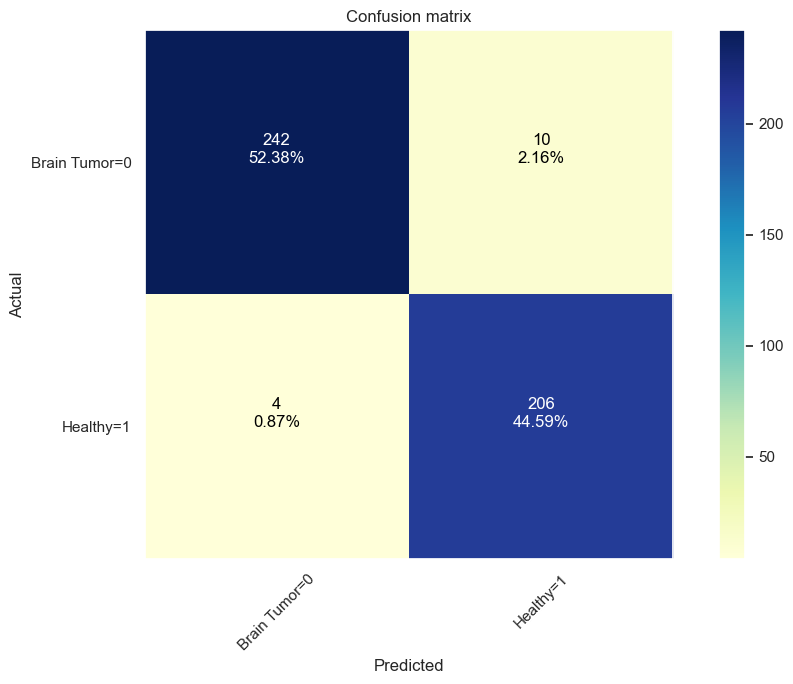

In [25]:
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

show_confusion_matrix(cm, CLA_label)

## <b>11 Save Model </b>

In [26]:
torch.save(cnn_model, "Brain_Tumor_model.pt")

In [33]:
!pip install torchviz


  Obtaining dependency information for torchviz from https://files.pythonhosted.org/packages/5e/06/bea648249802b65282414caf5e7bc94fcb6e5a3e311b537845417d19edb9/torchviz-0.0.3-py3-none-any.whl.metadata
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 678.4 kB/s eta 0:00:000:00:01m


In [23]:
from torchviz import make_dot

In [24]:
dot = make_dot(model(X), params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('cnn_tumor_model') 

'cnn_tumor_model.png'

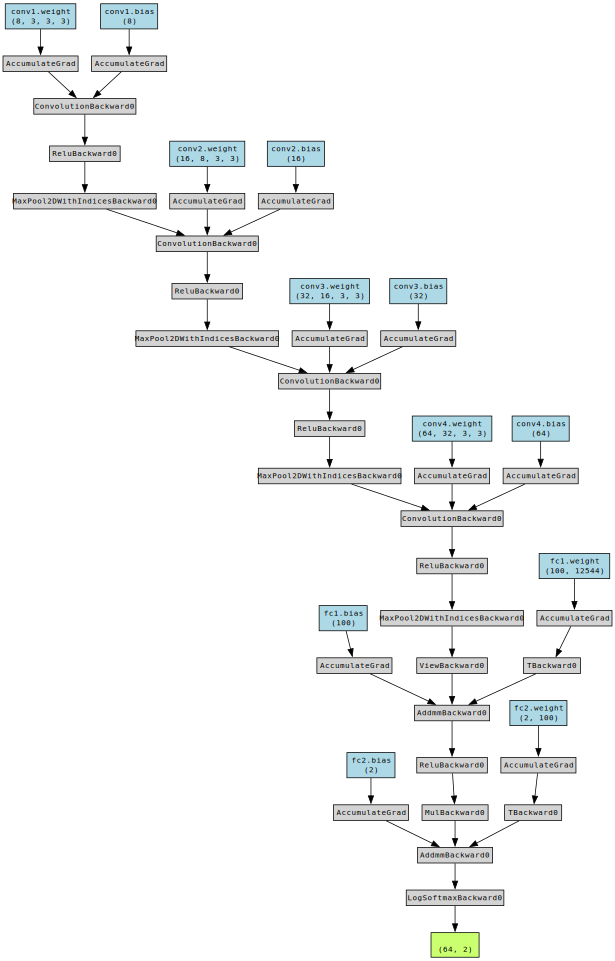

In [25]:
from IPython.display import display
dot = make_dot(model(X), params=dict(model.named_parameters()))
display(dot)

In [37]:
!pip install graphviz

In [22]:
from graphviz import Digraph

# Креирање на дијаграм
dot = Digraph()

# Додавање на слоевите
dot.node('Input', 'Input (1, 128, 128)')
dot.node('Conv1', 'Conv1\n3x3, 32 filters')
dot.node('Pool1', 'MaxPool2d\n2x2')
dot.node('Conv2', 'Conv2\n3x3, 64 filters')
dot.node('Pool2', 'MaxPool2d\n2x2')
dot.node('Conv3', 'Conv3\n3x3, 128 filters')
dot.node('Pool3', 'MaxPool2d\n2x2')
dot.node('Conv4', 'Conv4\n3x3, 256 filters')
dot.node('Pool4', 'MaxPool2d\n2x2')
dot.node('Flatten', 'Flatten')
dot.node('FC1', 'FC1\n128 neurons')
dot.node('Dropout', 'Dropout\np=0.5')
dot.node('FC2', 'FC2\n4 neurons')
dot.node('Output', 'Output\nLogSoftmax')

# Додавање на врските
dot.edge('Input', 'Conv1')
dot.edge('Conv1', 'Pool1')
dot.edge('Pool1', 'Conv2')
dot.edge('Conv2', 'Pool2')
dot.edge('Pool2', 'Conv3')
dot.edge('Conv3', 'Pool3')
dot.edge('Pool3', 'Conv4')
dot.edge('Conv4', 'Pool4')
dot.edge('Pool4', 'Flatten')
dot.edge('Flatten', 'FC1')
dot.edge('FC1', 'Dropout')
dot.edge('Dropout', 'FC2')
dot.edge('FC2', 'Output')

# Зачувување на дијаграмот
dot.format = 'png'
dot.render('cnn_tumor_model_graphviz')  # Зачувај го дијаграмот како 'cnn_tumor_model_graphviz.png'

'cnn_tumor_model_graphviz.png'